In [1]:
import os
from collections import Counter
from typing import Iterable

import numpy as np
from matplotlib import pyplot as plt

from eval.calculate_samples import StatsScore
from src.rplan.analysis import RPlanAnalysisProcessor, T, U, RPlanAnalysisVisualizer
from src.rplan.dataset import RPlanDataset
from src.rplan.types import Plan, RoomType

In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,  # Don't interpret text with LaTeX
    "pgf.rcfonts": False,  # Use current matplotlib font
})

In [3]:
class Analyzer(RPlanAnalysisVisualizer):

    def process(self, plan: Plan) -> T:
        corners_per_room = {room_type: [] for room_type in RoomType}
        for room in plan.rooms:
            corners_per_room[room.room_type].append(room.corners.shape[0])
        areas = {
            room_type: [] for room_type in RoomType
        }
        for room in plan.rooms:
            areas[room.room_type].append(room.area())

        return {
            'num_corners': np.array([room.corners.shape[0] for room in plan.rooms]),
            'total_points': np.sum([room.corners.shape[0] for room in plan.rooms]),
            'room_types': Counter([room.room_type for room in plan.rooms]),
            'num_rooms': len(plan.rooms),
            'corners_per_room': corners_per_room,
            'areas_per_room': areas,
            'area': np.sum([np.sum(areas) for areas in areas.values()]),
        }

    def aggregate(self, plans: Iterable[T]) -> U:
        return {
            'num_corners': np.concatenate([plan['num_corners'] for plan in plans]),
            'total_points': np.array([plan['total_points'] for plan in plans]),
            'room_types': sum((plan['room_types'] for plan in plans), Counter()),
            'num_rooms': np.array([plan['num_rooms'] for plan in plans]),
            'corners_per_room': {
                room_type: np.concatenate([plan['corners_per_room'][room_type] for plan in plans])
                for room_type in RoomType
            },
            'areas_per_room': {
                room_type: np.concatenate([plan['areas_per_room'][room_type] for plan in plans])
                for room_type in RoomType
            },
            'areas': np.array([plan['area'] for plan in plans]),
        }

    def visualize(self, data: U, include_latex: bool = False):
        if include_latex:
            os.makedirs('pgf', exist_ok=True)
        plt.hist(data['num_corners'])
        plt.title('Number of corners per room')
        plt.show()

        plt.hist(data['total_points'])
        plt.title('Number of points per plan')
        plt.show()

        plt.bar([x.value for x in data['room_types'].keys()], data['room_types'].values())
        plt.title('Room types')
        plt.show()

        # plt.hist(data['num_rooms'], bins=np.arange(data['num_rooms'].min(), data['num_rooms'].max() + 1) - 0.5)
        labels, counts = np.unique(data['num_rooms'], return_counts=True)
        plt.bar(labels, counts, align='center')
        plt.gca().set_xticks(labels)
        plt.title('Number of rooms')
        plt.savefig('pgf/num_rooms.pgf', bbox_inches='tight', pad_inches=0.0, backend='pgf') if include_latex else None
        plt.show()

        area_stats = {
            room_type: StatsScore(data['areas_per_room'][room_type]) if len(
                data['areas_per_room'][room_type]) > 0 else StatsScore(np.array([0]))
            for room_type in RoomType
        }
        areas = [area_stats[room_type].mean for room_type in RoomType]
        area_errors = [area_stats[room_type].sem for room_type in RoomType]
        plt.bar([x.value for x in RoomType], areas, yerr=area_errors, capsize=5)
        plt.title('Average area per room type')
        plt.xlabel('Room Type')
        plt.ylabel('Area (m²)')
        plt.xticks([x.value for x in RoomType], [x.name for x in RoomType])

        num_room_types = len(RoomType)
        rows = np.ceil(np.sqrt(num_room_types)).astype(int)
        cols = num_room_types // rows
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        for i, room_type in enumerate(RoomType):
            ax = axes[i // cols, i % cols]
            ax.hist(data['corners_per_room'][room_type])
            ax.set_title(f'Number of corners per {room_type.name}')

        plt.show()

In [4]:
dataset = RPlanDataset('../data/rplan', load_all=True)

Loading cached RPlan dataset


In [5]:
analyzer = Analyzer()
data = dataset.analyze(analyzer)

In [6]:
stats = StatsScore(data['areas'])

In [7]:
stats.mean, stats.sem

(np.float64(17784.874031233423), np.float64(9.21365824598657))

In [14]:
area_data = {
    'per_room_type': {
        room_type.name: StatsScore(data['areas_per_room'][room_type]).mean.item() if len(
            data['areas_per_room'][room_type]) > 0 else None for room_type in RoomType
    },
    'total': StatsScore(data['areas']).mean.item() if len(data['areas']) > 0 else None,
}

with open("../src/rplan/area_constants.py", "w") as f:
    f.write(f"from src.rplan.types import RoomType\n\n")
    f.write("MEAN_AREA_PER_ROOM_TYPE = { \n")
    for room_type, area in area_data['per_room_type'].items():
        if area is None:
            continue
        f.write(f"    RoomType.{room_type}: {area},\n")
    f.write("}\n\n")
    f.write(f"TOTAL_MEAN_AREA = {area_data['total']}\n")


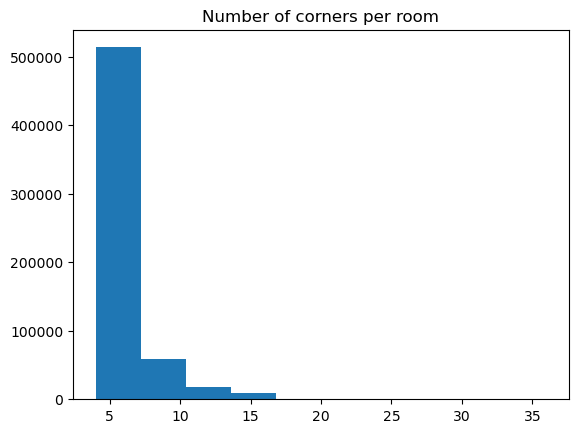

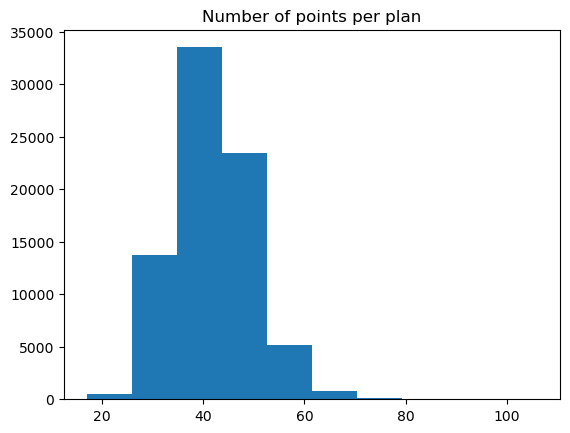

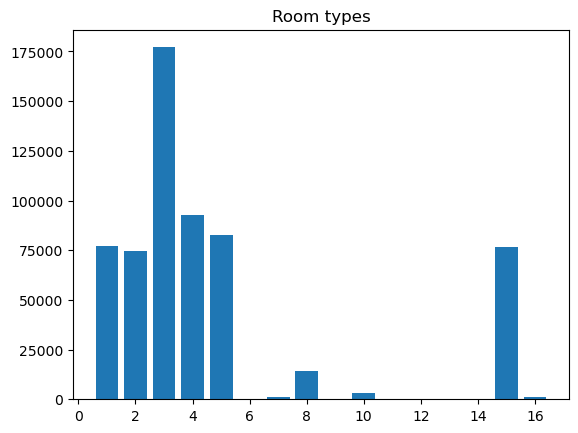

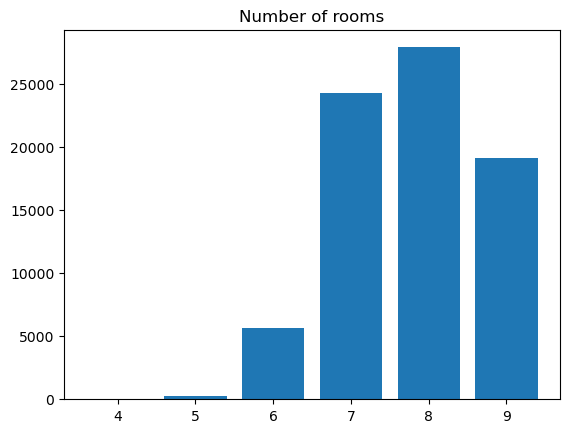

/opt/homebrew/Caskroom/miniconda/base/envs/torch-3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniconda/base/envs/torch-3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


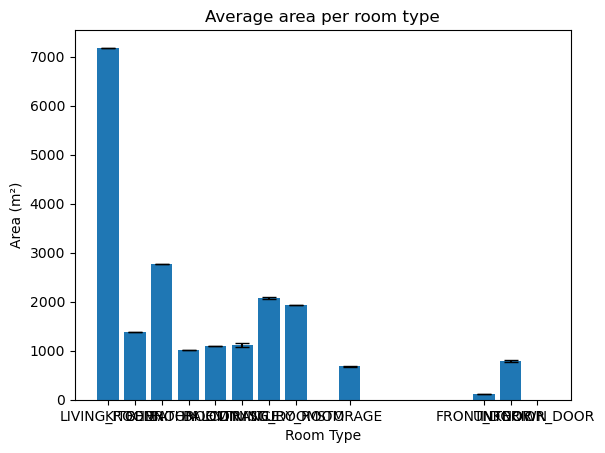

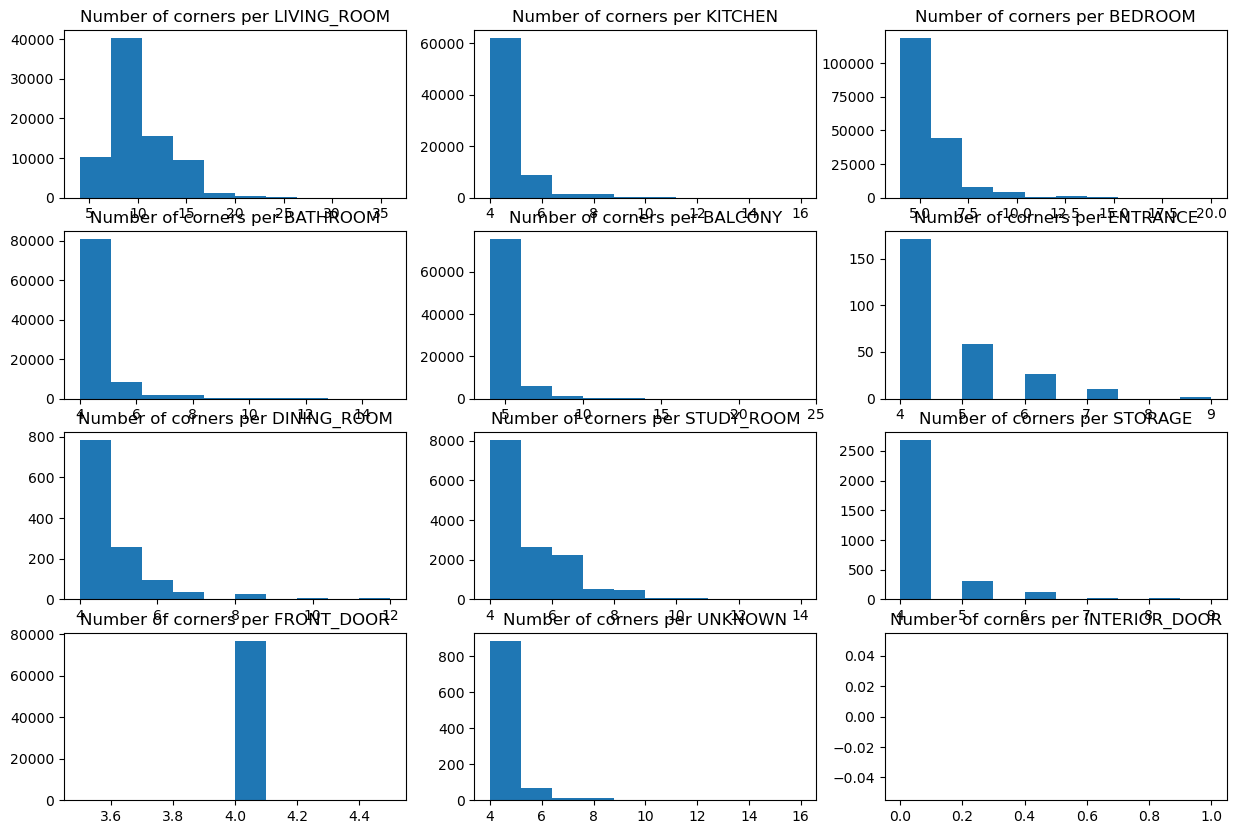

In [9]:
analyzer.visualize(data, include_latex=True)